In [0]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0
!pip install keract

Uninstalling tensorflow-2.2.0rc1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc1
     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 40.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=fcc320c6c9421811bdee48280a43143e195ee515348ed5bf93357ed61f7a13d8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully u

In [18]:
!git clone https://github.com/DatenBiene/Medical_Time_Series_Classification.git

Cloning into 'Medical_Time_Series_Classification'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 423 (delta 87), reused 105 (delta 35), pack-reused 241
Receiving objects: 100% (423/423), 27.66 MiB | 18.94 MiB/s, done.
Resolving deltas: 100% (218/218), done.


In [0]:
import os 
os.chdir('/content/Medical_Time_Series_Classification')

# Imports

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
#import keract
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score
import keras
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from utils.evaluation import *
from utils.utils import read_dataset,split_dataset
%matplotlib inline

# 1. Data importation and visualization

In [0]:
X_train,y_train,X_val,y_val,X_test,y_test = np.load('data/ECG5000/ECG5000_full.npy',allow_pickle=True)

data = np.concatenate([X_train,X_val,X_test])
labels = np.concatenate([y_train,y_val,y_test])

In [0]:
y_train_1H = np.zeros((len(y_train),5))
y_val_1H = np.zeros((len(y_val),5))
y_test_1H = np.zeros((len(y_test),5))

for k in range(len(y_train)):
  y_train_1H[k,y_train[k]-1] += 1

for k in range(len(y_val)):
  y_val_1H[k,y_val[k]-1] += 1

for k in range(len(y_test)):
  y_test_1H[k,y_test[k]-1] += 1

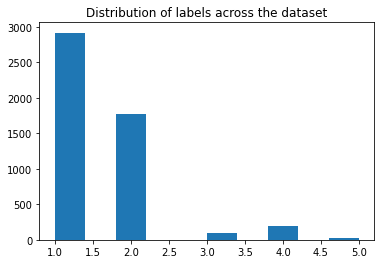

In [24]:
plt.hist(labels)
plt.title('Distribution of labels across the dataset')
plt.show()

In [25]:
unique_labels,props = np.unique(labels,return_counts=True)
df_props = pd.DataFrame([],columns=['proportion'],index = unique_labels)
df_props.index.name='label'
df_props['proportion'] = props/np.sum(props)
df_props

,proportion
label,
1,0.5838
2,0.3534
3,0.0192
4,0.0388
5,0.0048


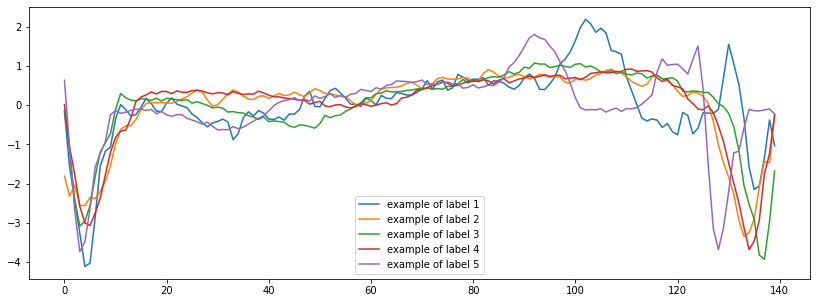

In [26]:
fig = plt.figure(figsize=(14,5))
for c in set(labels):
    spe_ecg = data[labels==c][0]
    plt.plot(spe_ecg,label='example of label '+str(c))

plt.legend()
plt.show()

# 2. Testing models

In [0]:
%matplotlib inline

## 2.1 Test MLP

In [0]:
from models.mlp import Classifier_MLP

In [29]:
mlp = Classifier_MLP(output_directory='outputs/output_mlp/',input_shape=(X_train.shape[1],),
                     nb_classes = 5,verbose=True,
                     hidden_layers_size=(70,35),min_lr=0.05)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 140)               0         
_________________________________________________________________
dropout (Dropout)            (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 70)                9870      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                2485      
_________________________________________________________________
dropout_2 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1

Train on 4000 samples, validate on 500 samples
Epoch 1/100
4000/4000 [==============================] - 1s 185us/sample - loss: 2.0661 - accuracy: 0.1268 - val_loss: 1.9348 - val_accuracy: 0.1020
Epoch 2/100
4000/4000 [==============================] - 0s 101us/sample - loss: 2.0418 - accuracy: 0.1240 - val_loss: 1.9059 - val_accuracy: 0.1020
Epoch 3/100
4000/4000 [==============================] - 0s 100us/sample - loss: 2.0019 - accuracy: 0.1390 - val_loss: 1.8765 - val_accuracy: 0.1140
Epoch 4/100
4000/4000 [==============================] - 0s 102us/sample - loss: 1.9579 - accuracy: 0.1560 - val_loss: 1.8469 - val_accuracy: 0.1360
Epoch 5/100
4000/4000 [==============================] - 0s 102us/sample - loss: 1.9284 - accuracy: 0.1565 - val_loss: 1.8169 - val_accuracy: 0.1580
Epoch 6/100
4000/4000 [==============================] - 0s 97us/sample - loss: 1.9051 - accuracy: 0.1632 - val_loss: 1.7869 - val_accuracy: 0.1660
Epoch 7/100
4000/4000 [==============================] - 0s 

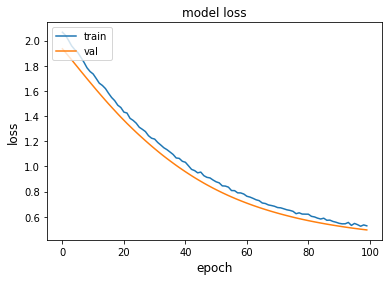

In [30]:
hist = mlp.fit(X_train,y_train_1H,X_val,y_val_1H,y_val,batch_size=32,nb_epochs=100)

Let's evaluate our predictions on the validation set: 

In [31]:
mlp = tf.keras.models.load_model('outputs/output_mlp/best_model.hdf5')
y_pred = mlp.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)+1
evaluate(y_test,y_pred)

,accuracy,recall,precision,f1-score
0,0.908,0.385721,0.359586,0.372107


Let's be more precise on each class. The following scores are computed considering each label against all the others.

In [32]:
get_binary_metrics(y_val,y_pred)

,recall,precision,f1-score
1,0.60223,0.532895,0.565445
2,0.395722,0.377551,0.386423
3,0,0,0
4,0,0,0
5,0,0,0


/content/Medical_Time_Series_Classification/utils/evaluation.py:36: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm/cm.sum(axis=0),3)


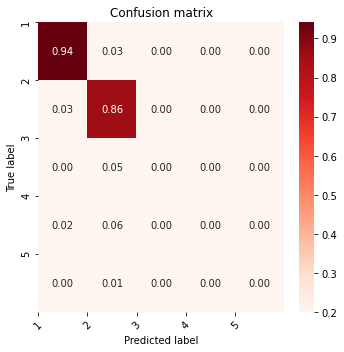

In [34]:
plot_confusion_matrix(y_test,y_pred)

## 2.2 Test ResNet

In [0]:
from models.resnet import Classifier_RESNET

In [0]:
#resnet requires a different shape since it is based on convolutional layers
X_train_1D = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_val_1D = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
X_test_1D = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [37]:
resnet = Classifier_RESNET('outputs/output_resnet/',input_shape=(data.shape[1],1),nb_classes=5,verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 140, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 140, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 140, 64)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

Train on 4000 samples, validate on 500 samples
Epoch 1/5
4000/4000 [==============================] - 9s 2ms/sample - loss: 0.2810 - accuracy: 0.9250 - val_loss: 0.9703 - val_accuracy: 0.7420
Epoch 2/5
4000/4000 [==============================] - 2s 528us/sample - loss: 0.2313 - accuracy: 0.9373 - val_loss: 0.3698 - val_accuracy: 0.9080
Epoch 3/5
4000/4000 [==============================] - 2s 552us/sample - loss: 0.2003 - accuracy: 0.9413 - val_loss: 0.3017 - val_accuracy: 0.9100
Epoch 4/5
4000/4000 [==============================] - 2s 546us/sample - loss: 0.1906 - accuracy: 0.9440 - val_loss: 0.2827 - val_accuracy: 0.9180
Epoch 5/5
4000/4000 [==============================] - 2s 531us/sample - loss: 0.1786 - accuracy: 0.9490 - val_loss: 0.2773 - val_accuracy: 0.9120


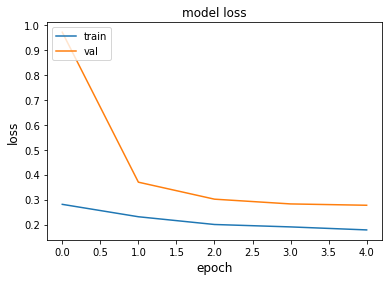

In [38]:
%matplotlib inline
hist = resnet.fit(X_train_1D,y_train_1H,X_val_1D,y_val_1H,y_val,batch_size=16,nb_epochs=5)

In [39]:
resnet = tf.keras.models.load_model('outputs/output_resnet/best_model.hdf5')
y_pred = resnet.predict(X_test_1D)
y_pred = np.argmax(y_pred,axis=1)+1
evaluate(y_test,y_pred)

,accuracy,recall,precision,f1-score
0,0.958,0.637953,0.65703,0.623746


In [40]:
get_binary_metrics(y_test,y_pred)

,recall,precision,f1-score
1,0.996575,0.989796,0.993174
2,0.977401,0.945355,0.961111
3,0.9,0.6,0.72
4,0.315789,0.75,0.444444
5,0,0,0


/content/Medical_Time_Series_Classification/utils/evaluation.py:36: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm/cm.sum(axis=0),3)


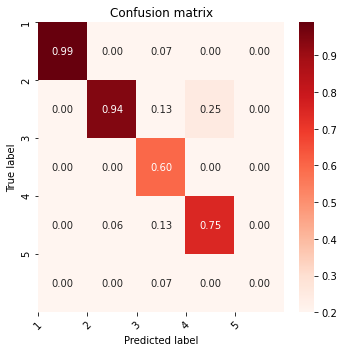

In [41]:
plot_confusion_matrix(y_test,y_pred)

## 2.3 Test 1D-CNN

In [0]:
from models.CNN_1D import Classifier_1DCNN

In [53]:
CNN_1D = Classifier_1DCNN('outputs/output_1DCNN/', nb_classes=5, n_conv_block=3, n_filters=[2,4,4],
                           kern_size=[16,32,32], n_stride=[1,1,1], input_shape=(data.shape[1],1), 
                           add_FC=False, n_unit_FC=1, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 140, 2)            34        
_________________________________________________________________
batch_normalization (BatchNo (None, 140, 2)            8         
_________________________________________________________________
activation (Activation)      (None, 140, 2)            0         
_________________________________________________________________
dropout (Dropout)            (None, 140, 2)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 2)            66        
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 2)            8         
_________________________________________________________________
activation_1 (Activation)    (None, 140, 2)            0

Train on 4000 samples, validate on 500 samples
Epoch 1/30
4000/4000 [==============================] - 5s 1ms/sample - loss: 0.3334 - accuracy: 0.9147 - val_loss: 0.3932 - val_accuracy: 0.9000
Epoch 2/30
4000/4000 [==============================] - 2s 515us/sample - loss: 0.2489 - accuracy: 0.9325 - val_loss: 0.2975 - val_accuracy: 0.9060
Epoch 3/30
4000/4000 [==============================] - 2s 532us/sample - loss: 0.2349 - accuracy: 0.9392 - val_loss: 0.3165 - val_accuracy: 0.9000
Epoch 4/30
4000/4000 [==============================] - 2s 520us/sample - loss: 0.2178 - accuracy: 0.9420 - val_loss: 0.2862 - val_accuracy: 0.9120
Epoch 5/30
4000/4000 [==============================] - 2s 519us/sample - loss: 0.2058 - accuracy: 0.9433 - val_loss: 0.2909 - val_accuracy: 0.9020
Epoch 6/30
4000/4000 [==============================] - 2s 528us/sample - loss: 0.1969 - accuracy: 0.9445 - val_loss: 0.2830 - val_accuracy: 0.9120
Epoch 7/30
4000/4000 [==============================] - 2s 521us/sa

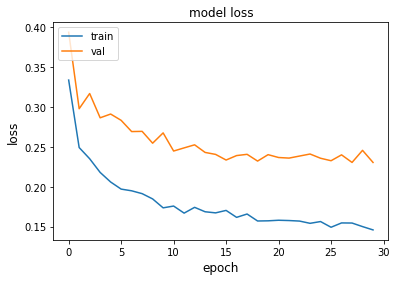

CPU times: user 1min 8s, sys: 2.99 s, total: 1min 11s
Wall time: 1min 6s


In [54]:
%%time
%matplotlib inline
hist = CNN_1D.fit(X_train_1D,y_train_1H,X_val_1D,y_val_1H,y_val,batch_size=16,nb_epochs=30)

In [55]:
CNN_1D = tf.keras.models.load_model('outputs/output_1DCNN/best_model.hdf5',custom_objects={'SWA': tfa.optimizers.SWA})
y_pred = CNN_1D.predict(X_test_1D)
y_pred = np.argmax(y_pred,axis=1)+1
evaluate(y_test,y_pred)

,accuracy,recall,precision,f1-score
0,0.96,0.620658,0.701459,0.635485


In [56]:
get_binary_metrics(y_test,y_pred)

,recall,precision,f1-score
1,0.993151,0.996564,0.994854
2,0.99435,0.926316,0.959128
3,0.8,0.727273,0.761905
4,0.315789,0.857143,0.461538
5,0,0,0


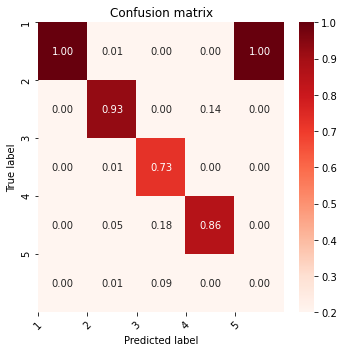

In [57]:
plot_confusion_matrix(y_test,y_pred)

#3. Interpreting models

In [0]:
from interpretation.cam import display_conv_activations

## 3.1 ResNet model

In [0]:
resnet_model = tf.keras.models.load_model('outputs/output_resnet/best_model.hdf5')

ypred = np.argmax(resnet_model.predict(X_test_1D),axis=1)
not_normal = []
for i in range(len(ypred)):
    if not ypred[i]==0: 
        not_normal.append(i)

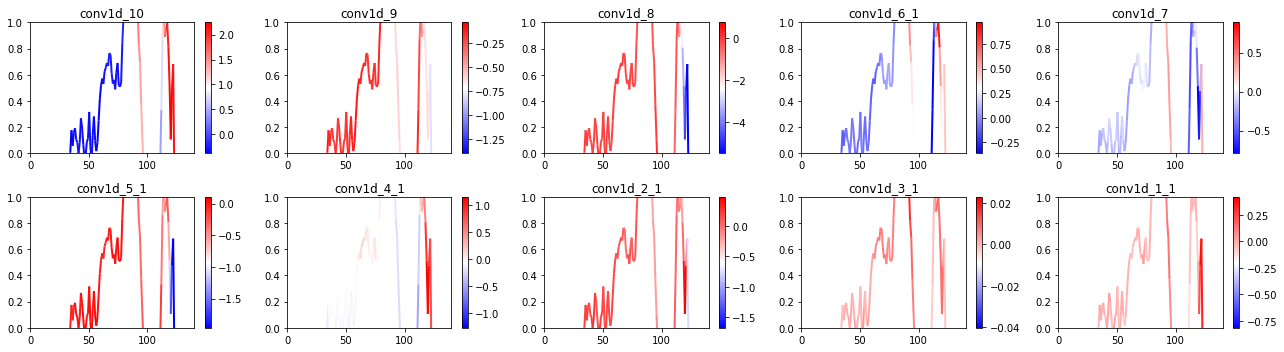

In [0]:
display_conv_activations(resnet_model,X_test_1D[not_normal[0]])

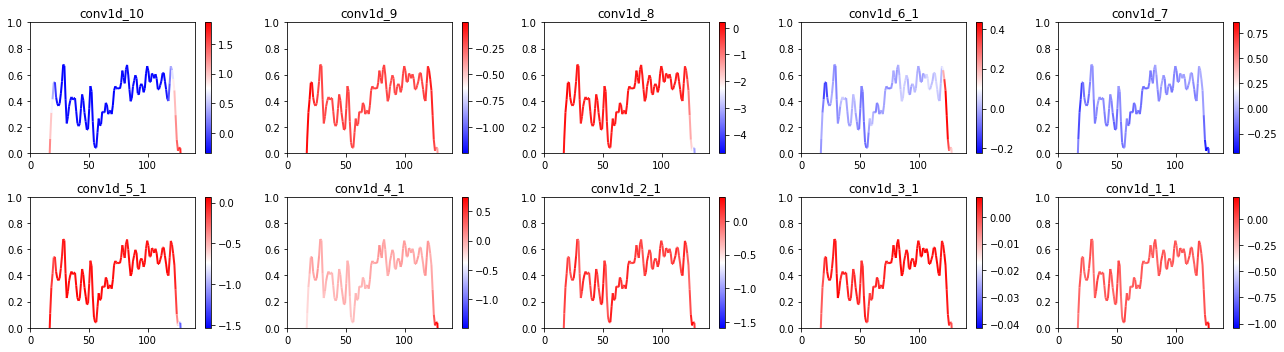

In [0]:
display_conv_activations(resnet_model,X_test_1D[not_normal[1]])

## 3.2 1DCNN model

In [0]:
CNN_1D = tf.keras.models.load_model('outputs/output_1DCNN/best_model.hdf5',custom_objects={'SWA': tfa.optimizers.SWA})

ypred = np.argmax(CNN_1D.predict(X_test_1D),axis=1)
not_normal = []
for i in range(len(ypred)):
    if not ypred[i]==0: 
        not_normal.append(i)

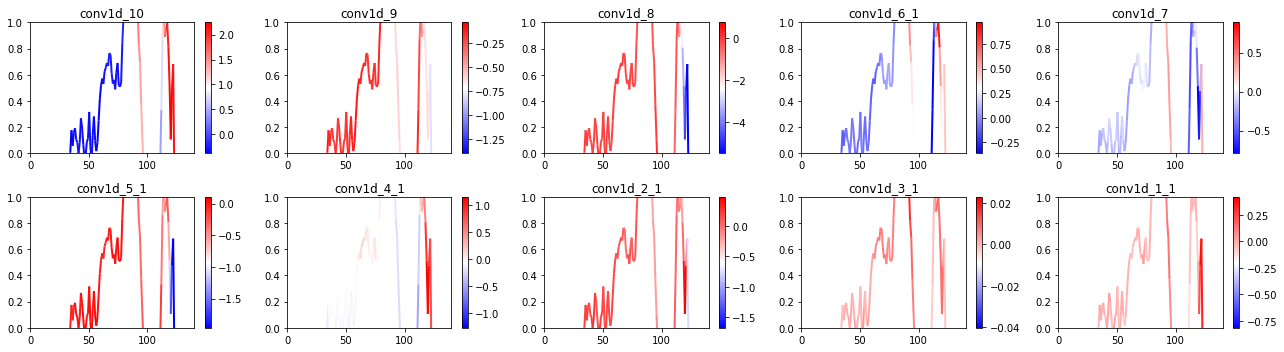

In [0]:
display_conv_activations(resnet_model,X_test_1D[not_normal[0]])

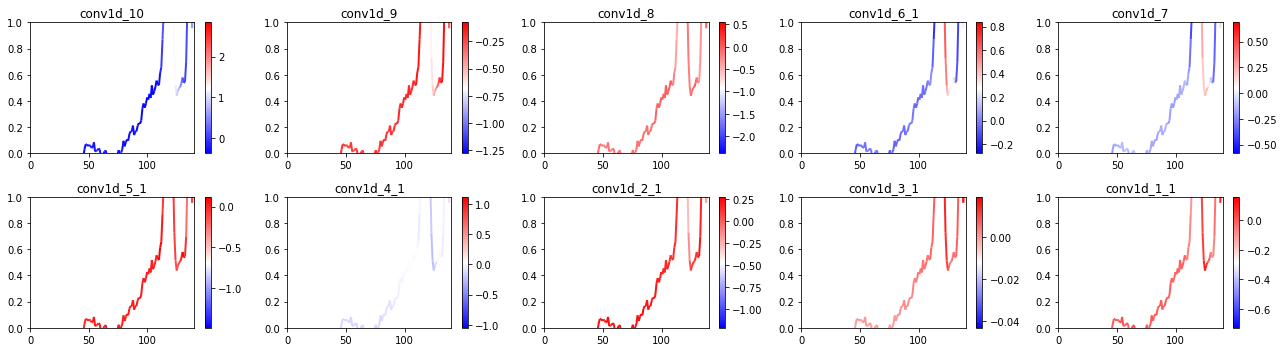

In [0]:
display_conv_activations(resnet_model,X_test_1D[not_normal[1]])